In [27]:
import sys
from pathlib import Path
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from wespeaker.cli.speaker import load_model
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F



import pandas as pd
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

PROJECT_ROOT = Path.cwd().parents[0]
sys.path.append(str(PROJECT_ROOT))
print("PROJECT_ROOT =", PROJECT_ROOT)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

speaker = load_model(PROJECT_ROOT / "wespeaker-voxceleb-resnet293-LM")
net = speaker.model
net = net.to(DEVICE)

print("ResNet-293 loaded from HF")

PROJECT_ROOT = /home/SpeakerRec/BioVoice
Using device: cuda
{'data_type': 'shard', 'dataloader_args': {'batch_size': 32, 'drop_last': True, 'num_workers': 16, 'pin_memory': False, 'prefetch_factor': 8}, 'dataset_args': {'aug_prob': 0.6, 'fbank_args': {'dither': 1.0, 'frame_length': 25, 'frame_shift': 10, 'num_mel_bins': 80}, 'num_frms': 200, 'shuffle': True, 'shuffle_args': {'shuffle_size': 2500}, 'spec_aug': False, 'spec_aug_args': {'max_f': 8, 'max_t': 10, 'num_f_mask': 1, 'num_t_mask': 1, 'prob': 0.6}, 'speed_perturb': True}, 'exp_dir': 'exp/ResNet293-TSTP-emb256-fbank80-num_frms200-aug0.6-spTrue-saFalse-ArcMargin-SGD-epoch150', 'gpus': [0, 1], 'log_batch_interval': 100, 'loss': 'CrossEntropyLoss', 'loss_args': {}, 'margin_scheduler': 'MarginScheduler', 'margin_update': {'epoch_iter': 17062, 'final_margin': 0.2, 'fix_start_epoch': 40, 'increase_start_epoch': 20, 'increase_type': 'exp', 'initial_margin': 0.0, 'update_margin': True}, 'model': 'ResNet293', 'model_args': {'embed_dim': 2

/home/SpeakerRec/BioVoice/.venvResnet/lib/python3.10/site-packages/wespeaker/utils/checkpoint.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pa

ResNet-293 loaded from HF


In [28]:
wav_dir = PROJECT_ROOT / "data" / "wavs"

SPEAKERS = ["eden", "idan", "yoav"]
speaker_to_id = {s: i for i, s in enumerate(SPEAKERS)}
id_to_speaker = {i: s for s, i in speaker_to_id.items()}

def speaker_from_name(p: Path) -> str | None:
    name = p.stem.lower()
    for s in SPEAKERS:
        if name.startswith(s + "_"):
            return s
    return None

all_items = []
for p in sorted(wav_dir.glob("*.wav")):
    s = speaker_from_name(p)
    if s is None:
        continue
    all_items.append((p, speaker_to_id[s], s))

print("Total wavs:", len(all_items))
for s in SPEAKERS:
    print(s, "=", sum(1 for _, _, sp in all_items if sp == s))


Total wavs: 90
eden = 30
idan = 30
yoav = 30


In [29]:
def embed_with_resnet_293(wav_path, l2_norm: bool = True):
    waveform, sr = torchaudio.load(wav_path)
    if sr != 16000:
        waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)(
            waveform
        )

    # Move waveform to the same device as the model
    waveform = waveform.to(DEVICE)

    # Use the speaker object's extract_embedding_from_pcm method
    embedding = speaker.extract_embedding_from_pcm(waveform, 16000)

    if l2_norm:
        embedding = embedding / (embedding.norm(p=2) + 1e-12)
    
    return embedding.squeeze()

In [30]:
def set_seed(seed=1234):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(1234)

X = []
y = []
paths = []
speakers = []

for p, label, spk in all_items:
    emb = embed_with_resnet_293(str(p), l2_norm=True)  # [192] on CPU
    X.append(emb)
    y.append(label)
    paths.append(p)
    speakers.append(spk)

X = torch.stack(X, dim=0)          # [N, 192]
y = torch.tensor(y, dtype=torch.long)  # [N]

print("X:", X.shape, "y:", y.shape)

# # optional: save to disk so you never re-embed unless you change data
# cache_path = PROJECT_ROOT / "data" / "redim_team_embeddings.pt"
# torch.save({"X": X, "y": y, "paths": paths, "speakers": speakers}, cache_path)
# print("Saved cache to:", cache_path)

X: torch.Size([90, 256]) y: torch.Size([90])


In [31]:
def split_indices_by_speaker(paths, speakers, val_ratio=0.2, seed=1234):
    rng = random.Random(seed)
    idx_by_spk = {s: [] for s in SPEAKERS}
    for i, spk in enumerate(speakers):
        idx_by_spk[spk].append(i)

    train_idx, val_idx = [], []
    for spk, idxs in idx_by_spk.items():
        rng.shuffle(idxs)
        n_val = max(1, int(len(idxs) * val_ratio))
        val_idx.extend(idxs[:n_val])
        train_idx.extend(idxs[n_val:])

    rng.shuffle(train_idx)
    rng.shuffle(val_idx)
    return train_idx, val_idx

train_idx, val_idx = split_indices_by_speaker(paths, speakers, val_ratio=0.2, seed=1234)
print("train:", len(train_idx), "val:", len(val_idx))


train: 72 val: 18


In [32]:

X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val     = X[val_idx], y[val_idx]

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val, y_val), batch_size=128, shuffle=False)


In [33]:
class SpeakerHead(nn.Module):
    def __init__(self, in_dim=192, num_classes=3):
        super().__init__()
        self.fc = nn.Linear(in_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

head = SpeakerHead(in_dim=X.shape[1], num_classes=len(SPEAKERS)).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(head.parameters(), lr=1e-3, weight_decay=1e-4)

def eval_loss_and_acc(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)

            logits = model(xb)
            loss = criterion(logits, yb)

            total_loss += loss.item() * yb.size(0)
            pred = logits.argmax(dim=1)
            correct += (pred == yb).sum().item()
            total += yb.numel()

    avg_loss = total_loss / max(1, total)
    acc = correct / max(1, total)
    return avg_loss, acc


train_loss_hist = []
val_loss_hist = []
train_acc_hist = []
val_acc_hist = []

best_val = -1.0
best_state = None

EPOCHS = 120
for epoch in range(1, EPOCHS + 1):
    head.train()
    running_loss = 0.0

    for xb, yb in train_loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)

        optimizer.zero_grad()
        logits = head(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * yb.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    val_loss, val_acc = eval_loss_and_acc(head, val_loader, criterion)
    _, train_acc = eval_loss_and_acc(head, train_loader, criterion)

    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)
    train_acc_hist.append(train_acc)
    val_acc_hist.append(val_acc)

    if val_acc > best_val:
        best_val = val_acc
        best_state = {k: v.detach().cpu().clone() for k, v in head.state_dict().items()}

    if epoch % 5 == 0 or epoch == 1:
        print(
            f"epoch {epoch:3d} | "
            f"train_loss {train_loss:.4f} | val_loss {val_loss:.4f} | "
            f"train_acc {train_acc:.3f} | val_acc {val_acc:.3f} | best {best_val:.3f}"
        )

head.load_state_dict(best_state)
head.eval()
print("Best val acc:", best_val)

epoch   1 | train_loss 1.0845 | val_loss 1.0802 | train_acc 0.681 | val_acc 0.667 | best 0.667
epoch   5 | train_loss 1.0269 | val_loss 1.0249 | train_acc 0.944 | val_acc 0.833 | best 0.833
epoch  10 | train_loss 0.9609 | val_loss 0.9605 | train_acc 1.000 | val_acc 1.000 | best 1.000
epoch  15 | train_loss 0.8996 | val_loss 0.9009 | train_acc 1.000 | val_acc 1.000 | best 1.000
epoch  20 | train_loss 0.8422 | val_loss 0.8447 | train_acc 1.000 | val_acc 1.000 | best 1.000
epoch  25 | train_loss 0.7885 | val_loss 0.7920 | train_acc 1.000 | val_acc 1.000 | best 1.000
epoch  30 | train_loss 0.7386 | val_loss 0.7431 | train_acc 1.000 | val_acc 1.000 | best 1.000
epoch  35 | train_loss 0.6921 | val_loss 0.6974 | train_acc 1.000 | val_acc 1.000 | best 1.000
epoch  40 | train_loss 0.6489 | val_loss 0.6548 | train_acc 1.000 | val_acc 1.000 | best 1.000
epoch  45 | train_loss 0.6085 | val_loss 0.6151 | train_acc 1.000 | val_acc 1.000 | best 1.000
epoch  50 | train_loss 0.5712 | val_loss 0.5782 | 

In [34]:
head_path = PROJECT_ROOT / "data" / "resnet_293_speaker_head.pt"
torch.save(
    {
        "state_dict": head.state_dict(),
        "speaker_to_id": speaker_to_id,
        "speakers": SPEAKERS,
        "l2_norm_emb": True, 
    },
    head_path,
)
print("Saved head to:", head_path)


Saved head to: /home/SpeakerRec/BioVoice/data/resnet_293_speaker_head.pt


In [35]:
import pandas as pd

@torch.no_grad()
def score_wav(path: Path):
    emb = embed_with_resnet_293(str(path), l2_norm=True).to(DEVICE)  # [192]
    logits = head(emb.unsqueeze(0)).squeeze(0)                        # [3]
    probs = F.softmax(logits, dim=0).detach().cpu().numpy()

    pred_id = int(np.argmax(probs))
    pred_spk = id_to_speaker[pred_id]

    # second best prob
    sorted_probs = np.sort(probs)[::-1]
    best_p = float(sorted_probs[0])
    second_p = float(sorted_probs[1])

    return probs, pred_spk, best_p, second_p

rows = []
for (p, true_id, true_spk) in all_items:
    probs, pred_spk, best_p, second_p = score_wav(p)
    p_true = float(probs[true_id])
    margin = p_true - second_p  # strong confidence when large

    rows.append({
        "path": str(p),
        "file": p.name,
        "true": true_spk,
        "pred": pred_spk,
        "p_true": p_true,
        "margin": margin,
        "p_eden": float(probs[speaker_to_id["eden"]]),
        "p_idan": float(probs[speaker_to_id["idan"]]),
        "p_yoav": float(probs[speaker_to_id["yoav"]]),
    })

df = pd.DataFrame(rows)
df["correct"] = df["true"] == df["pred"]

print("overall accuracy on all wavs (not just val):", df["correct"].mean())

# Top-N representatives per speaker
TOP_N = 3
for spk in SPEAKERS:
    top = df[df["true"] == spk].sort_values(["margin", "p_true"], ascending=False).head(TOP_N)
    print("\n==== TOP", TOP_N, "for", spk, "====")
    display(top[["file", "true", "pred", "p_true", "margin", "p_eden", "p_idan", "p_yoav"]])


overall accuracy on all wavs (not just val): 1.0

==== TOP 3 for eden ====


,file,true,pred,p_true,margin,p_eden,p_idan,p_yoav
29,eden_030.wav,eden,eden,0.373465,0.058275,0.373465,0.315190,0.311346
2,eden_003.wav,eden,eden,0.367626,0.050455,0.367626,0.317171,0.315203
10,eden_011.wav,eden,eden,0.370562,0.048198,0.370562,0.307075,0.322363



==== TOP 3 for idan ====


,file,true,pred,p_true,margin,p_eden,p_idan,p_yoav
57,idan_028.wav,idan,idan,0.408084,0.109212,0.298873,0.408084,0.293043
58,idan_029.wav,idan,idan,0.405484,0.107873,0.297611,0.405484,0.296905
56,idan_027.wav,idan,idan,0.406471,0.106194,0.300278,0.406471,0.293251



==== TOP 3 for yoav ====


,file,true,pred,p_true,margin,p_eden,p_idan,p_yoav
80,yoav_021.wav,yoav,yoav,0.411161,0.110336,0.300824,0.288015,0.411161
66,yoav_007.wav,yoav,yoav,0.404087,0.101224,0.302863,0.293050,0.404087
62,yoav_003.wav,yoav,yoav,0.402769,0.099638,0.303131,0.294101,0.402769


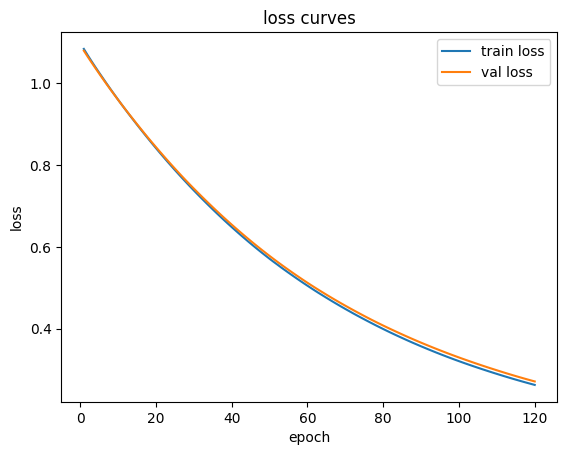

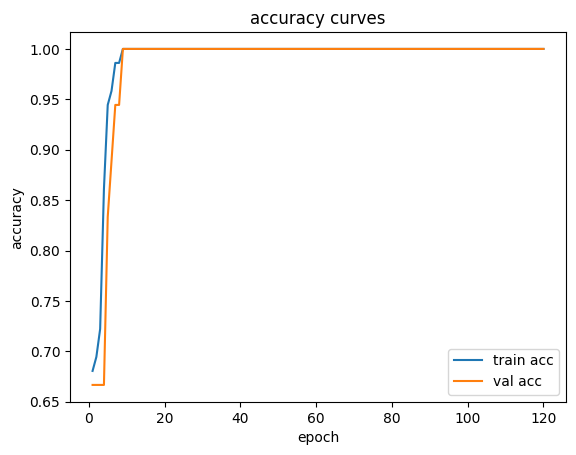

In [36]:
epochs = np.arange(1, len(train_loss_hist) + 1)

plt.figure()
plt.plot(epochs, train_loss_hist, label="train loss")
plt.plot(epochs, val_loss_hist, label="val loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.title("loss curves")
plt.show()

plt.figure()
plt.plot(epochs, train_acc_hist, label="train acc")
plt.plot(epochs, val_acc_hist, label="val acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.title("accuracy curves")
plt.show()


In [37]:
cm = pd.crosstab(df["true"], df["pred"], rownames=["true"], colnames=["pred"])
display(cm)

per_class_acc = (df["true"] == df["pred"]).groupby(df["true"]).mean()
display(per_class_acc)

pred,eden,idan,yoav
true,,,
eden,30,0,0
idan,0,30,0
yoav,0,0,30


true
eden    1.0
idan    1.0
yoav    1.0
dtype: float64

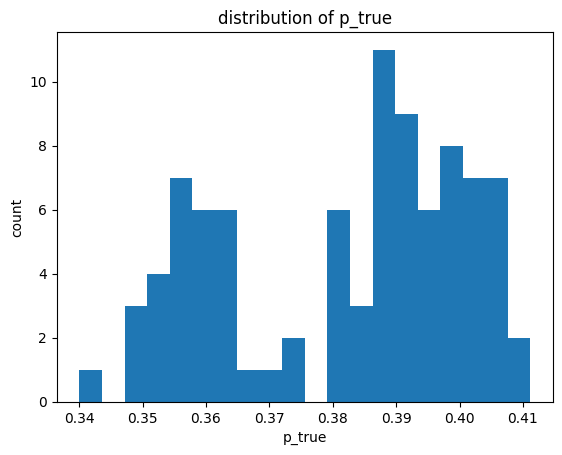

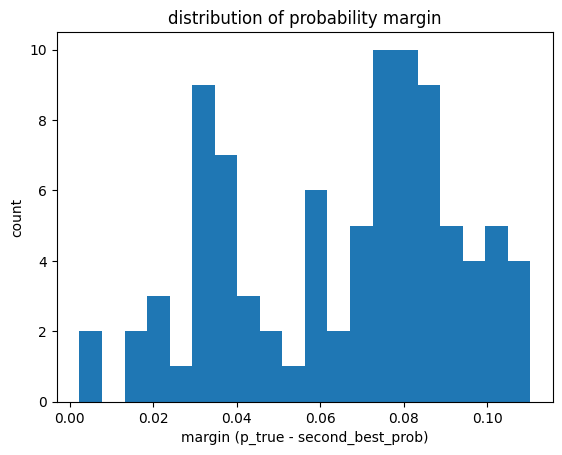

In [38]:
plt.figure()
plt.hist(df["p_true"].values, bins=20)
plt.xlabel("p_true")
plt.ylabel("count")
plt.title("distribution of p_true")
plt.show()

plt.figure()
plt.hist(df["margin"].values, bins=20)
plt.xlabel("margin (p_true - second_best_prob)")
plt.ylabel("count")
plt.title("distribution of probability margin")
plt.show()
